# Introduction
In this notebook, I will show how to apply deep learning on time series problem. In this problem we are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the next month.

### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is     1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

# Table of Contents
* Importing Libraries
* Reading the data
* EDA & Data Preprocessing
* Time Series Processing
* Deep Learning Models
* Prediction on test set

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from keras.optimizers import Adam
from keras import Model

# Reading the data

In [2]:
df1 = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
df2 = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
df3 = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv', parse_dates = ['date']) 
df4 = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [3]:
df1.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
df2.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
df3.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [6]:
df4.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Join the datasets

In [7]:
df = df3.join(df2, on='item_id', rsuffix='_').join(df4, on='shop_id', rsuffix='_').join(df1, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_','item_category_id_'], axis=1)

In [8]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [9]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


## Time Period of dataset

In [10]:
print("Min date from the dataset: %s" % df['date'].min())
print("Max date from the dataset: %s" % df['date'].max())

Min date from the dataset: 2013-01-01 00:00:00
Max date from the dataset: 2015-12-10 00:00:00


# EDA & Data Preprocessing

### Firstly, let's check for outliers

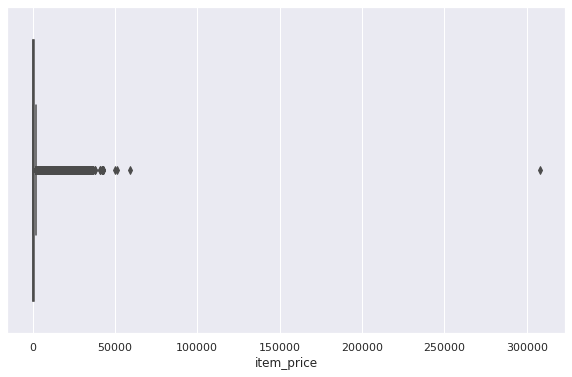

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(df['item_price'])
plt.show()

I will treat "item_price" >= 400000 as outliers, so I'll remove them.

In [12]:
df = df.query('item_price < 40000')

### Data Preprocessing
* We will first take only the columns which we require.
* Then we will sort the table according to the date column.
* Next, we are asked to predict total sales for every product and store in the next month, and our data is given by day, so we aggregate the data by month.

In [13]:
train_monthly = df[['date', 'date_block_num','shop_id', 'item_id', 'item_cnt_day']]
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']

In [14]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_cnt
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


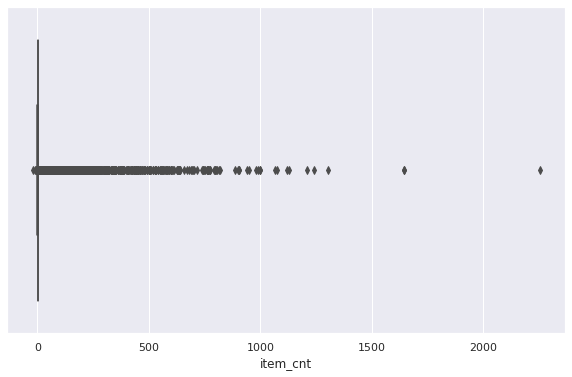

In [15]:
plt.figure(figsize=(10,6))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

In [16]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')

In [17]:
train_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596735 entries, 0 to 1609112
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date_block_num  1596735 non-null  int64  
 1   shop_id         1596735 non-null  int64  
 2   item_id         1596735 non-null  int64  
 3   item_cnt        1596735 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 60.9 MB


### Grouping data for EDA

In [18]:
month_mean = train_monthly.groupby(['date_block_num'], as_index=False)['item_cnt'].mean()
shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()

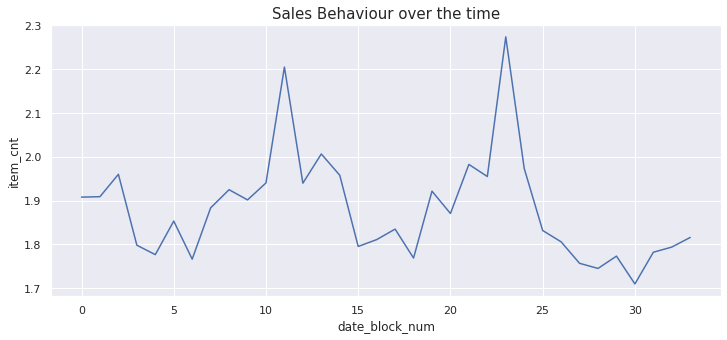

In [19]:
fig =  plt.figure(figsize=(12, 5))
sns.lineplot(x='date_block_num', y='item_cnt', data=month_mean)
plt.title("Sales Behaviour over the time", fontsize=15)
plt.show()

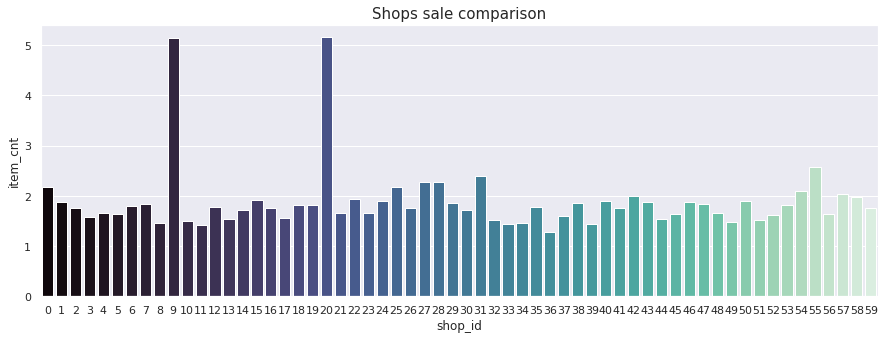

In [20]:
fig =  plt.figure(figsize=(15, 5))
sns.barplot(x='shop_id', y='item_cnt', data=shop_mean, palette="mako")
plt.title("Shops sale comparison", fontsize=15)
plt.show()

# Time-series processing
* As we only need the "item_cnt" feature as a series, we can get that easily by just using a pivot operation.
* This way we will also get the missing months from each "shop_id" and "item_id", and then replace them with 0.

In [21]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns = 'date_block_num', values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,36,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we will merge with our test data so that the model performs well on test dataset. 

In [22]:
data = pd.merge(test, monthly_series, on=['item_id', 'shop_id'], how='left')
data.fillna(0, inplace=True)
data.drop(['shop_id', 'item_id', 'ID'], inplace=True, axis=1)

In [23]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Then, for the value of X we will keep all the columns except the last one as we have to predict that column.<br> So the y will be the last column.

In [24]:
X = data.iloc[:,:-1]
X.shape

(214200, 33)

In [25]:
y = data.iloc[:,-1:]
y.shape

(214200, 1)

In [26]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lastly, we reshape our data in this form:- <br>
Time-series shape - (data points, time-steps, features).

In [27]:
X  = X.values.reshape(X.shape[0], X.shape[1], 1)

# Model

## LSTM Model
First we will begin with a regular LSTM Model.

In [28]:
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(1, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 33, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 33, 4)             592       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 24        
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0

In [30]:
model.compile(optimizer='Adam', loss='mse', metrics=['mean_squared_error'])

In [31]:
model.fit(X, y, batch_size=64, epochs=5)

Epoch 1/5
3347/3347 [==============================] - 173s 52ms/step - loss: 0.7068 - mean_squared_error: 0.7068
Epoch 2/5
3347/3347 [==============================] - 178s 53ms/step - loss: 0.6542 - mean_squared_error: 0.6542
Epoch 3/5
3347/3347 [==============================] - 178s 53ms/step - loss: 0.6575 - mean_squared_error: 0.6575
Epoch 4/5
3347/3347 [==============================] - 179s 53ms/step - loss: 0.6555 - mean_squared_error: 0.6555
Epoch 5/5
3347/3347 [==============================] - 177s 53ms/step - loss: 0.6520 - mean_squared_error: 0.6520


## LSTM Autoencoder
* Now we will build an autoencoder. 
* Autoencoders are a type of self-supervised learning model that can learn a compressed representation of input data. The structural representation is shown below. <br>
<img src = "https://stackabuse.s3.amazonaws.com/media/image-reconstruction-and-denoising-with-autoencoders-in-python-and-keras-3.png" style = "height:20em"></img>
* The design of the autoencoder model purposefully makes this challenging by restricting the architecture to a bottleneck at the midpoint of the model, from which the reconstruction of the input data is performed.
* Here I have built a LSTM autoencoder. A LSTM Autoencoder is an implementation of an autoencoder for sequence data using an Encoder-Decoder LSTM architecture.
* For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it.
* After the models is trained we can keep only the encoder part and we'll have a model that is able to do what we want.

In [32]:
model2 = Sequential()
model2.add(LSTM(X.shape[1], activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model2.add(LSTM(32, activation='relu', return_sequences=True))
model2.add(LSTM(16, activation='relu', return_sequences=True))
model2.add(LSTM(6, activation='relu', return_sequences=True))
model2.add(LSTM(1, activation='relu'))
model2.add(RepeatVector(X.shape[1]))
model2.add(LSTM(X.shape[1], activation='relu', return_sequences=True))
model2.add(LSTM(32, activation='relu', return_sequences=True))
model2.add(LSTM(16, activation='relu', return_sequences=True))
model2.add(LSTM(6, activation='relu', return_sequences=True))
model2.add(TimeDistributed(Dense(1)))

In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 33, 33)            4620      
_________________________________________________________________
lstm_5 (LSTM)                (None, 33, 32)            8448      
_________________________________________________________________
lstm_6 (LSTM)                (None, 33, 16)            3136      
_________________________________________________________________
lstm_7 (LSTM)                (None, 33, 6)             552       
_________________________________________________________________
lstm_8 (LSTM)                (None, 1)                 32        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 33, 1)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 33, 33)           

In [34]:
model2.compile(optimizer='Adam', loss='mse', metrics=['mean_squared_error'])

In [35]:
model2.fit(X, y, batch_size=64, epochs=5)

Epoch 1/5
3347/3347 [==============================] - 356s 106ms/step - loss: 0.8510 - mean_squared_error: 0.8510
Epoch 2/5
3347/3347 [==============================] - 357s 107ms/step - loss: 0.8558 - mean_squared_error: 0.8558
Epoch 3/5
3347/3347 [==============================] - 363s 108ms/step - loss: 0.8511 - mean_squared_error: 0.8511
Epoch 4/5
3347/3347 [==============================] - 359s 107ms/step - loss: 0.8509 - mean_squared_error: 0.8509
Epoch 5/5
3347/3347 [==============================] - 361s 108ms/step - loss: 0.8509 - mean_squared_error: 0.8509


### Extracting encoding model
After training the model, we will take only the encoded part of the model and define it as new one.

In [36]:
encoder = Model(inputs=model2.inputs, outputs=model2.layers[4].output)

# Prediction on test set

### Build test set

In [37]:
test = data.iloc[:,1:]

In [38]:
test  = test.values.reshape(test.shape[0], test.shape[1], 1)
test.shape

(214200, 33, 1)

### Regular LSTM Model prediction

In [39]:
result = model.predict(test)

### LSTM Autoencoder Model prediction

In [40]:
result_2 = encoder.predict(test)

### This is all about this notebook. I hope now you will get some basic idea on how we can do a time series problem. 
## Thank you for reading this notebook.